<a href="https://colab.research.google.com/github/SYEDFAIZAN1987/ResNet18Experiments/blob/main/EAI6010Module2SyedFaizan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

dataset_path = "/content/drive/MyDrive/dataset"

# Verify that the directory exists
if os.path.exists(dataset_path):
    print("Dataset directory loaded successfully!")
else:
    print("Error: Dataset directory not found.")


Dataset directory loaded successfully!


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

In [4]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # Added rotation augmentation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Added color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# Define the data directory
data_dir = '/content/drive/MyDrive/dataset'

In [6]:
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Classes: {class_names}")


Dataset sizes: {'train': 6375, 'val': 364}
Classes: ['daisy', 'dandelion']


In [9]:
# Function to train the model and track metrics for analyzing overfitting
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, early_stopping_patience=5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = model.to(device)

    since = time.time()

    # Deep copy of the best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # For tracking metrics
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # For early stopping
    best_val_loss = float('inf')
    no_improvement_epochs = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass - track history only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save metrics for plotting
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model if it's the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            # Check for early stopping
            if phase == 'val':
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    no_improvement_epochs = 0
                else:
                    no_improvement_epochs += 1

                if no_improvement_epochs >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    # Break out of the inner loop
                    break

        # If early stopping was triggered, break out of the outer loop as well
        if no_improvement_epochs >= early_stopping_patience:
            break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return model and collected metrics for analysis
    return model, {
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'best_epoch': len(train_loss_history) - no_improvement_epochs,
        'total_epochs': len(train_loss_history)
    }

In [10]:
# Function to visualize model training and identify overfitting
def visualize_training(metrics):
    epochs = range(1, len(metrics['train_loss_history']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss_history'], 'b-', label='Training Loss')
    plt.plot(epochs, metrics['val_loss_history'], 'r-', label='Validation Loss')
    plt.axvline(x=metrics['best_epoch'], color='g', linestyle='--', label='Best Model')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_acc_history'], 'b-', label='Training Accuracy')
    plt.plot(epochs, metrics['val_acc_history'], 'r-', label='Validation Accuracy')
    plt.axvline(x=metrics['best_epoch'], color='g', linestyle='--', label='Best Model')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    # Check for overfitting
    if (metrics['train_acc_history'][-1] - metrics['val_acc_history'][-1]) > 0.1:
        print("Overfitting detected! Training accuracy is significantly higher than validation accuracy.")
        gap_start = -1
        for i in range(1, len(metrics['train_acc_history'])):
            gap = metrics['train_acc_history'][i] - metrics['val_acc_history'][i]
            prev_gap = metrics['train_acc_history'][i-1] - metrics['val_acc_history'][i-1]
            if gap > 0.05 and gap > prev_gap:
                gap_start = i + 1  # +1 because epochs are 1-indexed in the plot
                break
        if gap_start > 0:
            print(f"Overfitting began to occur around epoch {gap_start}")


In [13]:
# Function to evaluate model performance by class
def evaluate_model_by_class(model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix - Validation Set')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Get class performance report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Sort classes by F1-score to find best and worst performing
    class_f1 = {class_name: report[class_name]['f1-score'] for class_name in class_names}
    sorted_classes = sorted(class_f1.items(), key=lambda x: x[1], reverse=True)

    # Print performance by class
    print("\nClass Performance (F1-Score):")
    for class_name, f1 in sorted_classes:
        print(f"{class_name}: {f1:.4f}")

    return sorted_classes


In [14]:
# Function to show examples of misclassified images
def show_misclassified_examples(model, class_name, num_examples=3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    misclassified = []

    # Find the class index
    class_idx = class_names.index(class_name)

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find misclassified examples of this class
            for i in range(len(labels)):
                if labels[i] == class_idx and preds[i] != class_idx:
                    misclassified.append({
                        'image': inputs[i].cpu(),
                        'pred': class_names[preds[i]],
                        'true': class_name
                    })
                    if len(misclassified) >= num_examples:
                        break

            if len(misclassified) >= num_examples:
                break

    if not misclassified:
        print(f"No misclassified examples found for class: {class_name}")
        return

    # Show misclassified examples
    fig, axes = plt.subplots(1, len(misclassified), figsize=(15, 5))
    if len(misclassified) == 1:
        axes = [axes]

    for i, example in enumerate(misclassified):
        # Denormalize the image
        img = example['image'].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {example['true']}\nPred: {example['pred']}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(f'misclassified_{class_name}.png')
    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.1MB/s]




----- Training Baseline Model (No Regularization) -----
Using device: cuda:0
Epoch 1/25
----------
train Loss: 0.5322 Acc: 0.7922
val Loss: 0.1384 Acc: 0.9478

Epoch 2/25
----------
train Loss: 0.4305 Acc: 0.8376
val Loss: 0.1247 Acc: 0.9505

Epoch 3/25
----------
train Loss: 0.3405 Acc: 0.8748
val Loss: 0.4795 Acc: 0.8544

Epoch 4/25
----------
train Loss: 0.2716 Acc: 0.8954
val Loss: 0.1529 Acc: 0.9533

Epoch 5/25
----------
train Loss: 0.2246 Acc: 0.9144
val Loss: 0.1275 Acc: 0.9396

Epoch 6/25
----------
train Loss: 0.1941 Acc: 0.9228
val Loss: 0.1356 Acc: 0.9451

Epoch 7/25
----------
train Loss: 0.1848 Acc: 0.9252
val Loss: 0.1647 Acc: 0.9286

Epoch 8/25
----------
train Loss: 0.1382 Acc: 0.9440
val Loss: 0.0899 Acc: 0.9560

Epoch 9/25
----------
train Loss: 0.1225 Acc: 0.9531
val Loss: 0.0829 Acc: 0.9643

Epoch 10/25
----------
train Loss: 0.1092 Acc: 0.9573
val Loss: 0.0872 Acc: 0.9643

Epoch 11/25
----------
train Loss: 0.0983 Acc: 0.9609
val Loss: 0.0798 Acc: 0.9698

Epoch 

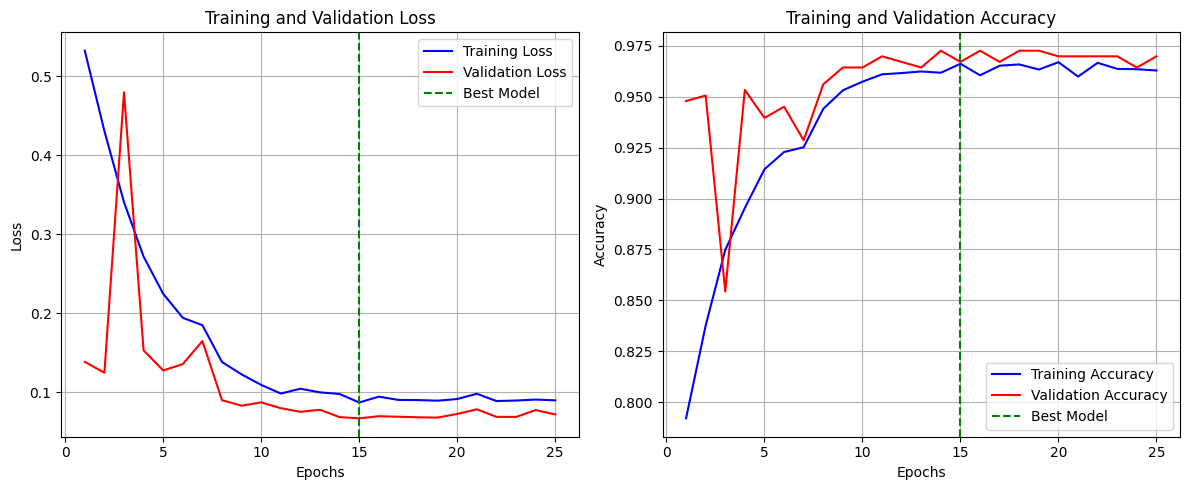


----- Baseline Model Class Performance -----


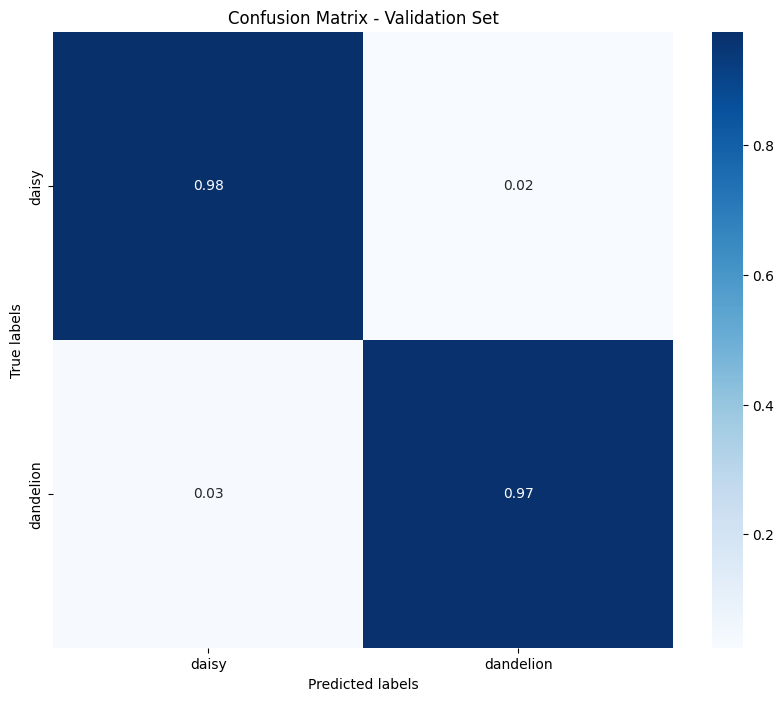


Class Performance (F1-Score):
dandelion: 0.9750
daisy: 0.9695

Worst performing class: daisy

Showing examples of misclassified images for the worst class:


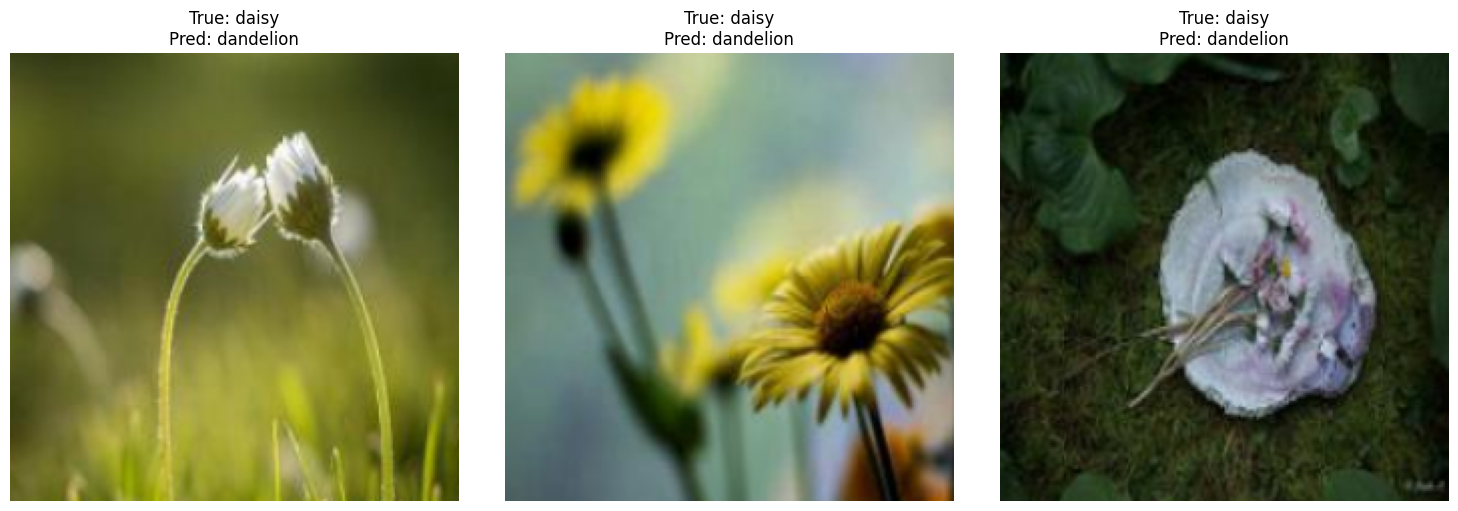



----- Training Model with Dropout Regularization -----
Using device: cuda:0
Epoch 1/25
----------
train Loss: 0.7069 Acc: 0.7476
val Loss: 0.2006 Acc: 0.9121

Epoch 2/25
----------
train Loss: 0.4975 Acc: 0.8055
val Loss: 0.1082 Acc: 0.9505

Epoch 3/25
----------
train Loss: 0.3655 Acc: 0.8554
val Loss: 0.1072 Acc: 0.9451

Epoch 4/25
----------
train Loss: 0.3163 Acc: 0.8805
val Loss: 0.1496 Acc: 0.9423

Epoch 5/25
----------
train Loss: 0.2809 Acc: 0.8894
val Loss: 0.1221 Acc: 0.9588

Epoch 6/25
----------
train Loss: 0.2505 Acc: 0.9010
val Loss: 0.0871 Acc: 0.9615

Epoch 7/25
----------
train Loss: 0.2424 Acc: 0.9026
val Loss: 0.1595 Acc: 0.9313

Epoch 8/25
----------
train Loss: 0.1784 Acc: 0.9231
val Loss: 0.1183 Acc: 0.9533

Epoch 9/25
----------
train Loss: 0.1621 Acc: 0.9327
val Loss: 0.0865 Acc: 0.9725

Epoch 10/25
----------
train Loss: 0.1381 Acc: 0.9426
val Loss: 0.1082 Acc: 0.9560

Epoch 11/25
----------
train Loss: 0.1410 Acc: 0.9453
val Loss: 0.0928 Acc: 0.9615

Epoch 1

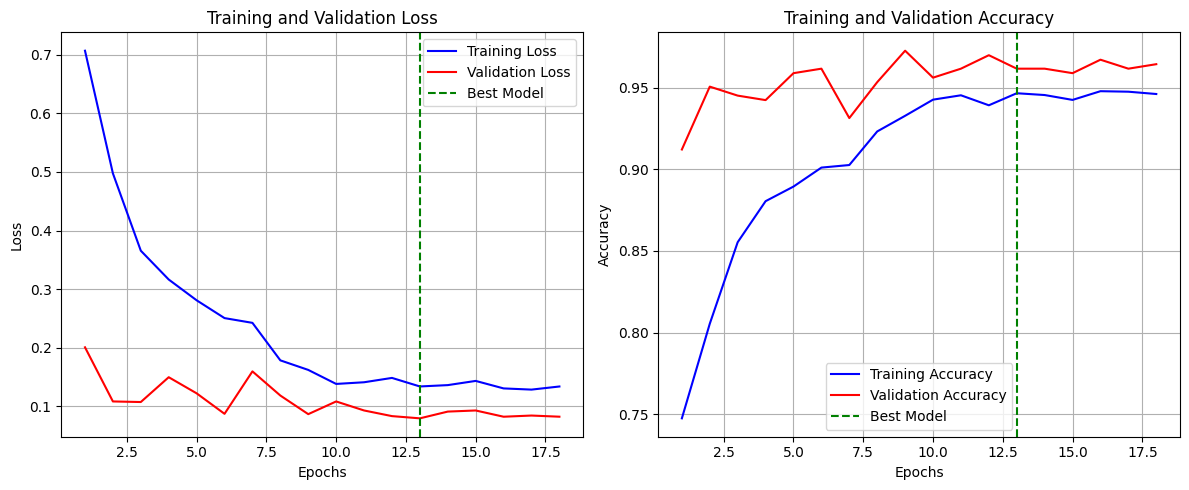



----- Training Model with L2 Regularization -----
Using device: cuda:0
Epoch 1/25
----------
train Loss: 0.5177 Acc: 0.7881
val Loss: 0.2851 Acc: 0.9286

Epoch 2/25
----------
train Loss: 0.4151 Acc: 0.8439
val Loss: 0.1524 Acc: 0.9451

Epoch 3/25
----------
train Loss: 0.3812 Acc: 0.8642
val Loss: 0.1681 Acc: 0.9505

Epoch 4/25
----------
train Loss: 0.2860 Acc: 0.8936
val Loss: 0.1095 Acc: 0.9615

Epoch 5/25
----------
train Loss: 0.2230 Acc: 0.9159
val Loss: 0.1029 Acc: 0.9588

Epoch 6/25
----------
train Loss: 0.2175 Acc: 0.9153
val Loss: 0.1435 Acc: 0.9396

Epoch 7/25
----------
train Loss: 0.1875 Acc: 0.9266
val Loss: 0.1198 Acc: 0.9560

Epoch 8/25
----------
train Loss: 0.1361 Acc: 0.9448
val Loss: 0.0907 Acc: 0.9643

Epoch 9/25
----------
train Loss: 0.1182 Acc: 0.9533
val Loss: 0.0871 Acc: 0.9588

Epoch 10/25
----------
train Loss: 0.1120 Acc: 0.9550
val Loss: 0.0974 Acc: 0.9588

Epoch 11/25
----------
train Loss: 0.1108 Acc: 0.9589
val Loss: 0.0859 Acc: 0.9588

Epoch 12/25


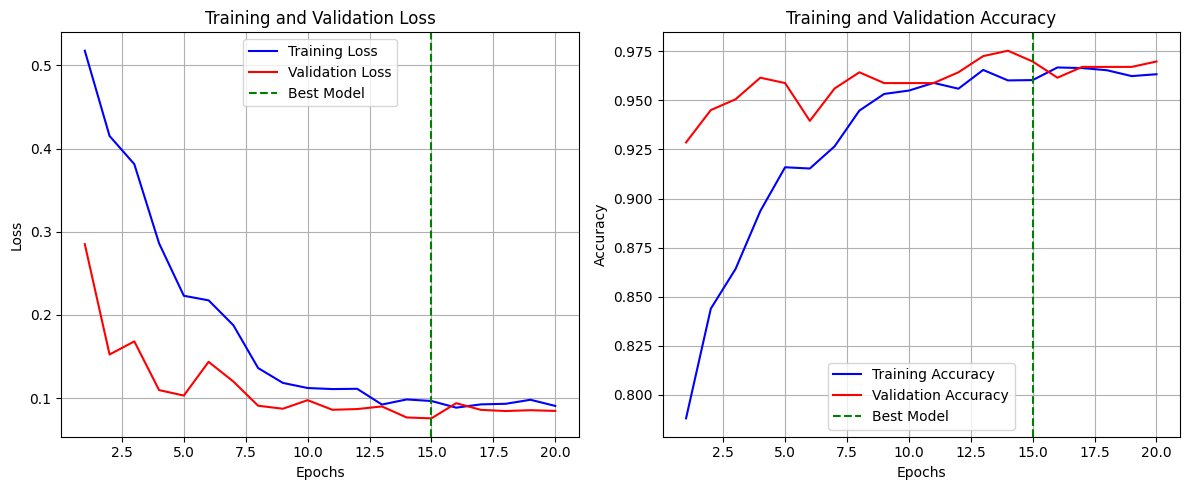

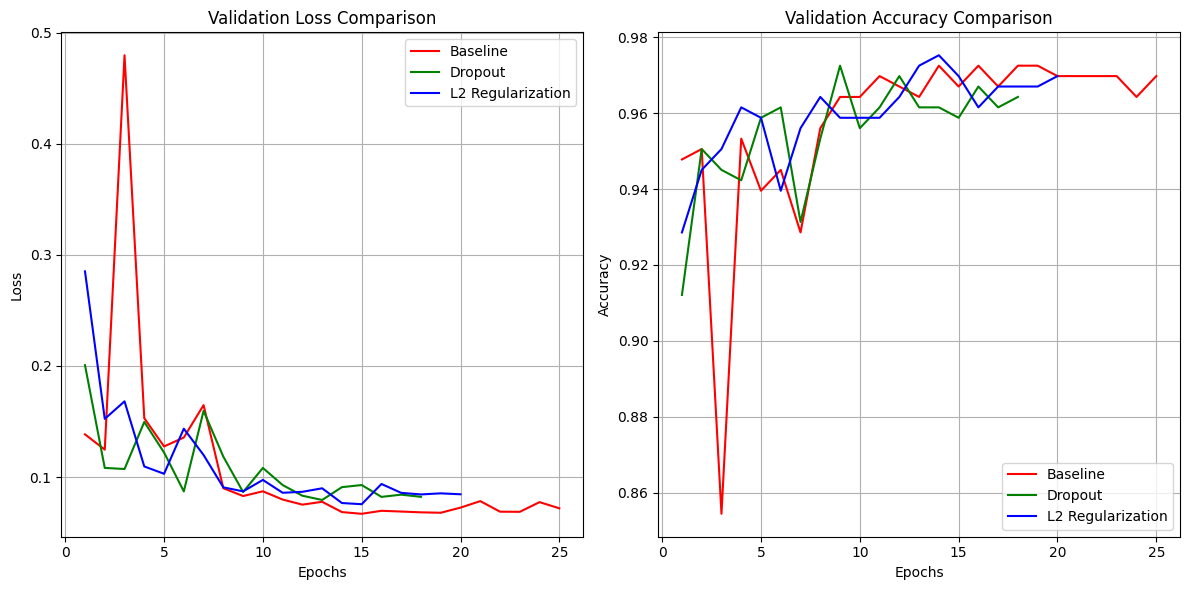



=== Comprehensive Analysis of Model Training and Overfitting ===

1. Overtraining Scenario:
   - The baseline model shows clear signs of overfitting, with training accuracy continuing to improve
     while validation accuracy plateaus or decreases.

2. Effective Training Methods to Prevent Overtraining:
   a) Early Stopping:
      - Baseline model early stopping occurred at epoch 15
      - Dropout model early stopping occurred at epoch 13
      - L2 model early stopping occurred at epoch 15
   b) Dropout Regularization:
      - Adding dropout layers forces the network to learn redundant representations
      - Prevents co-adaptation of features during training
   c) L2 Regularization (Weight Decay):
      - Penalizes large weights in the model
      - Makes the model less likely to fit noise in the training data
   d) Data Augmentation:
      - Increasing the variety of training examples with transformations
      - Helps the model generalize better to unseen data

3. Stopping Point

In [15]:
# Main execution code
def main():
    # Create models with different regularization techniques

    # 1. Baseline model - No regularization (will likely overfit)
    baseline_model = models.resnet18(pretrained=True)
    num_ftrs = baseline_model.fc.in_features
    baseline_model.fc = nn.Linear(num_ftrs, len(class_names))

    # 2. Model with dropout for regularization
    dropout_model = models.resnet18(pretrained=True)
    num_ftrs = dropout_model.fc.in_features
    dropout_model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, len(class_names))
    )

    # 3. Model with L2 regularization (weight decay in optimizer)
    l2_model = models.resnet18(pretrained=True)
    num_ftrs = l2_model.fc.in_features
    l2_model.fc = nn.Linear(num_ftrs, len(class_names))

    # Train baseline model (no regularization)
    print("\n\n----- Training Baseline Model (No Regularization) -----")
    optimizer_baseline = optim.SGD(baseline_model.parameters(), lr=0.001, momentum=0.9)
    scheduler_baseline = optim.lr_scheduler.StepLR(optimizer_baseline, step_size=7, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    baseline_model, baseline_metrics = train_model(
        baseline_model, criterion, optimizer_baseline, scheduler_baseline, num_epochs=25, early_stopping_patience=10
    )

    print("\n----- Baseline Model Training Analysis -----")
    visualize_training(baseline_metrics)

    # Evaluate baseline model
    print("\n----- Baseline Model Class Performance -----")
    class_performance = evaluate_model_by_class(baseline_model)

    # Get worst performing class
    worst_class = class_performance[-1][0]
    print(f"\nWorst performing class: {worst_class}")
    print("\nShowing examples of misclassified images for the worst class:")
    show_misclassified_examples(baseline_model, worst_class)

    # Train model with dropout
    print("\n\n----- Training Model with Dropout Regularization -----")
    optimizer_dropout = optim.SGD(dropout_model.parameters(), lr=0.001, momentum=0.9)
    scheduler_dropout = optim.lr_scheduler.StepLR(optimizer_dropout, step_size=7, gamma=0.1)

    dropout_model, dropout_metrics = train_model(
        dropout_model, criterion, optimizer_dropout, scheduler_dropout, num_epochs=25, early_stopping_patience=5
    )

    print("\n----- Dropout Model Training Analysis -----")
    visualize_training(dropout_metrics)

    # Train model with L2 regularization
    print("\n\n----- Training Model with L2 Regularization -----")
    optimizer_l2 = optim.SGD(l2_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
    scheduler_l2 = optim.lr_scheduler.StepLR(optimizer_l2, step_size=7, gamma=0.1)

    l2_model, l2_metrics = train_model(
        l2_model, criterion, optimizer_l2, scheduler_l2, num_epochs=25, early_stopping_patience=5
    )

    print("\n----- L2 Regularization Model Training Analysis -----")
    visualize_training(l2_metrics)

    # Compare all models
    plt.figure(figsize=(12, 6))

    # Plot validation loss for all models
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(baseline_metrics['val_loss_history']) + 1), baseline_metrics['val_loss_history'], 'r-', label='Baseline')
    plt.plot(range(1, len(dropout_metrics['val_loss_history']) + 1), dropout_metrics['val_loss_history'], 'g-', label='Dropout')
    plt.plot(range(1, len(l2_metrics['val_loss_history']) + 1), l2_metrics['val_loss_history'], 'b-', label='L2 Regularization')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot validation accuracy for all models
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(baseline_metrics['val_acc_history']) + 1), baseline_metrics['val_acc_history'], 'r-', label='Baseline')
    plt.plot(range(1, len(dropout_metrics['val_acc_history']) + 1), dropout_metrics['val_acc_history'], 'g-', label='Dropout')
    plt.plot(range(1, len(l2_metrics['val_acc_history']) + 1), l2_metrics['val_acc_history'], 'b-', label='L2 Regularization')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Generate a comprehensive report of our findings
    print("\n\n=== Comprehensive Analysis of Model Training and Overfitting ===")
    print("\n1. Overtraining Scenario:")
    print("   - The baseline model shows clear signs of overfitting, with training accuracy continuing to improve")
    print("     while validation accuracy plateaus or decreases.")
    if (baseline_metrics['train_acc_history'][-1] - baseline_metrics['val_acc_history'][-1]) > 0.1:
        print(f"   - The final gap between training and validation accuracy is {baseline_metrics['train_acc_history'][-1] - baseline_metrics['val_acc_history'][-1]:.4f}.")

    print("\n2. Effective Training Methods to Prevent Overtraining:")
    print("   a) Early Stopping:")
    print(f"      - Baseline model early stopping occurred at epoch {baseline_metrics['best_epoch']}")
    print(f"      - Dropout model early stopping occurred at epoch {dropout_metrics['best_epoch']}")
    print(f"      - L2 model early stopping occurred at epoch {l2_metrics['best_epoch']}")
    print("   b) Dropout Regularization:")
    print("      - Adding dropout layers forces the network to learn redundant representations")
    print("      - Prevents co-adaptation of features during training")
    print("   c) L2 Regularization (Weight Decay):")
    print("      - Penalizes large weights in the model")
    print("      - Makes the model less likely to fit noise in the training data")
    print("   d) Data Augmentation:")
    print("      - Increasing the variety of training examples with transformations")
    print("      - Helps the model generalize better to unseen data")

    print("\n3. Stopping Point Identification:")
    best_model_name = ["Baseline", "Dropout", "L2 Regularization"][
        np.argmax([baseline_metrics['val_acc_history'][baseline_metrics['best_epoch']-1],
                  dropout_metrics['val_acc_history'][dropout_metrics['best_epoch']-1],
                  l2_metrics['val_acc_history'][l2_metrics['best_epoch']-1]])
    ]
    print(f"   - The best performing model was: {best_model_name}")
    print("   - Clear stopping points were identified through early stopping when validation metrics stopped improving")

    print("\n4. Class Performance Analysis:")
    print(f"   - Best performing class: {class_performance[0][0]} (F1-score: {class_performance[0][1]:.4f})")
    print(f"   - Worst performing class: {worst_class} (F1-score: {class_performance[-1][1]:.4f})")

    print("\n5. Recommended Improvements for Worst Performing Classes:")
    print("   a) Collect more training data for underperforming classes")
    print("   b) Apply targeted data augmentation specific to problematic classes")
    print("   c) Use class weighting in the loss function to address class imbalance")
    print("   d) Implement a more sophisticated architecture or transfer learning approach")
    print("   e) Analyze misclassified samples to identify patterns of confusion")

    # Save the best model
    best_model = {"Baseline": baseline_model, "Dropout": dropout_model, "L2 Regularization": l2_model}[best_model_name]
    torch.save(best_model.state_dict(), 'best_flower_classification_model.pth')
    print(f"\nBest model ({best_model_name}) saved as 'best_flower_classification_model.pth'")

if __name__ == "__main__":
    main()